In [13]:
import copy
import json
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.special import logsumexp
from shapely.geometry import shape
from scipy.optimize import minimize

# Import data

In [48]:
# Select dataset
dataset = "commuter_borough" #"synthetic"
method = "R_squared"
constrained = 'singly'
gamma = 100

filename = f"{constrained}_rsquared_estimated_flows_gamma_{str(gamma)}"

In [23]:
# Import relevant data
origin_supply = np.loadtxt(f'../data/input/{dataset}/origin_supply.txt')
initial_destination_sizes = np.loadtxt(f'../data/input/{dataset}/initial_destination_sizes.txt')
cost_matrix = np.loadtxt(f'../data/input/{dataset}/cost_matrix.txt')
origins = np.loadtxt(f'../data/input/{dataset}/origins.txt',dtype='str')
destinations = np.loadtxt(f'../data/input/{dataset}/destinations.txt',dtype='str')


# Import actual and estimated matrix
actual_matrix = np.loadtxt(f'../data/input/{dataset}/od_matrix.txt')
that = np.loadtxt(f'../data/output/{dataset}/inverse_problem/singly_rsquared_estimated_flows_100.txt')

# Compute total flow
total_flow = np.sum(actual_matrix)
# Scale estimated flows
estimated_matrix = that*total_flow

# Round up
actual_matrix = actual_matrix.astype('int64')
estimated_matrix = estimated_matrix.astype('int64')

N,M = cost_matrix.shape

# Visualise matrices

In [24]:
# Actuals

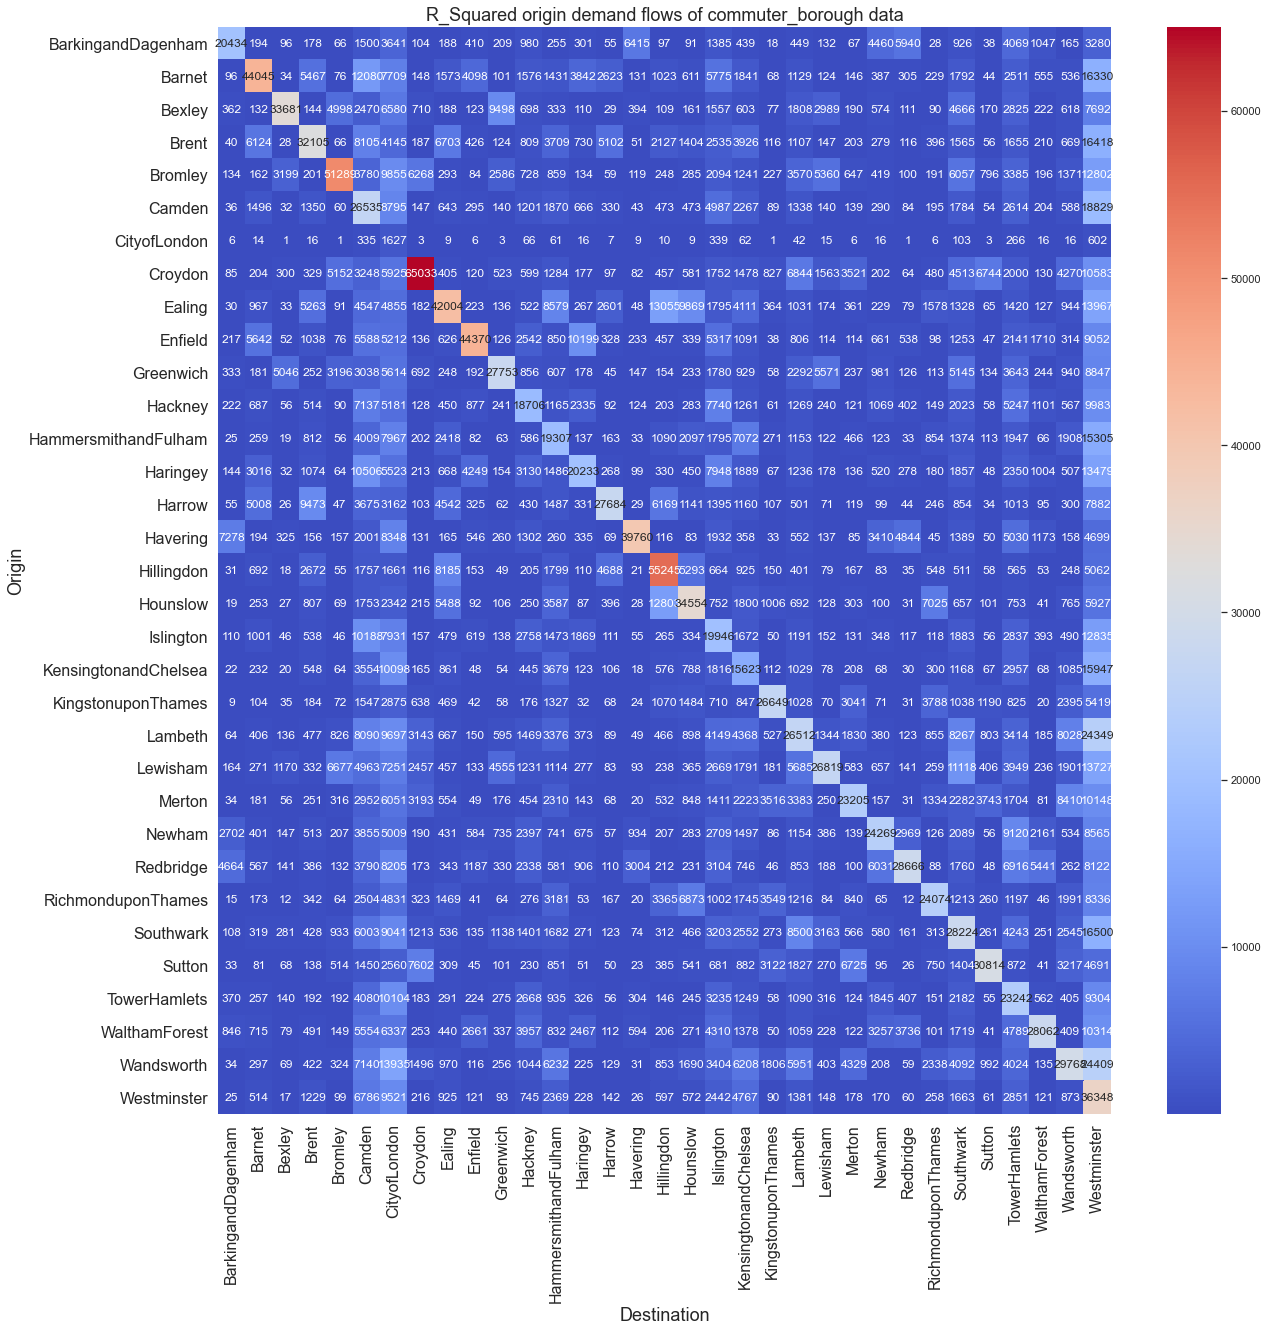

In [25]:
# Change font scaling
sns.set(font_scale=1)
# Set plot size
plt.figure(figsize=(20,20))
# Add heatmap
flow_heatmap = sns.heatmap(actual_matrix,
                            annot=True,
                            cmap="coolwarm",
                            fmt='d',
                            xticklabels=destinations,
                            yticklabels=origins)
# Add x,y axes labels
plt.xlabel("Destination",fontsize=18)
plt.ylabel("Origin",fontsize=18)
# Add title
plt.title('{} origin demand flows of {} data'.format(method.title(),dataset), fontsize=18)
# Increase tick font size
plt.tick_params(labelsize=16)

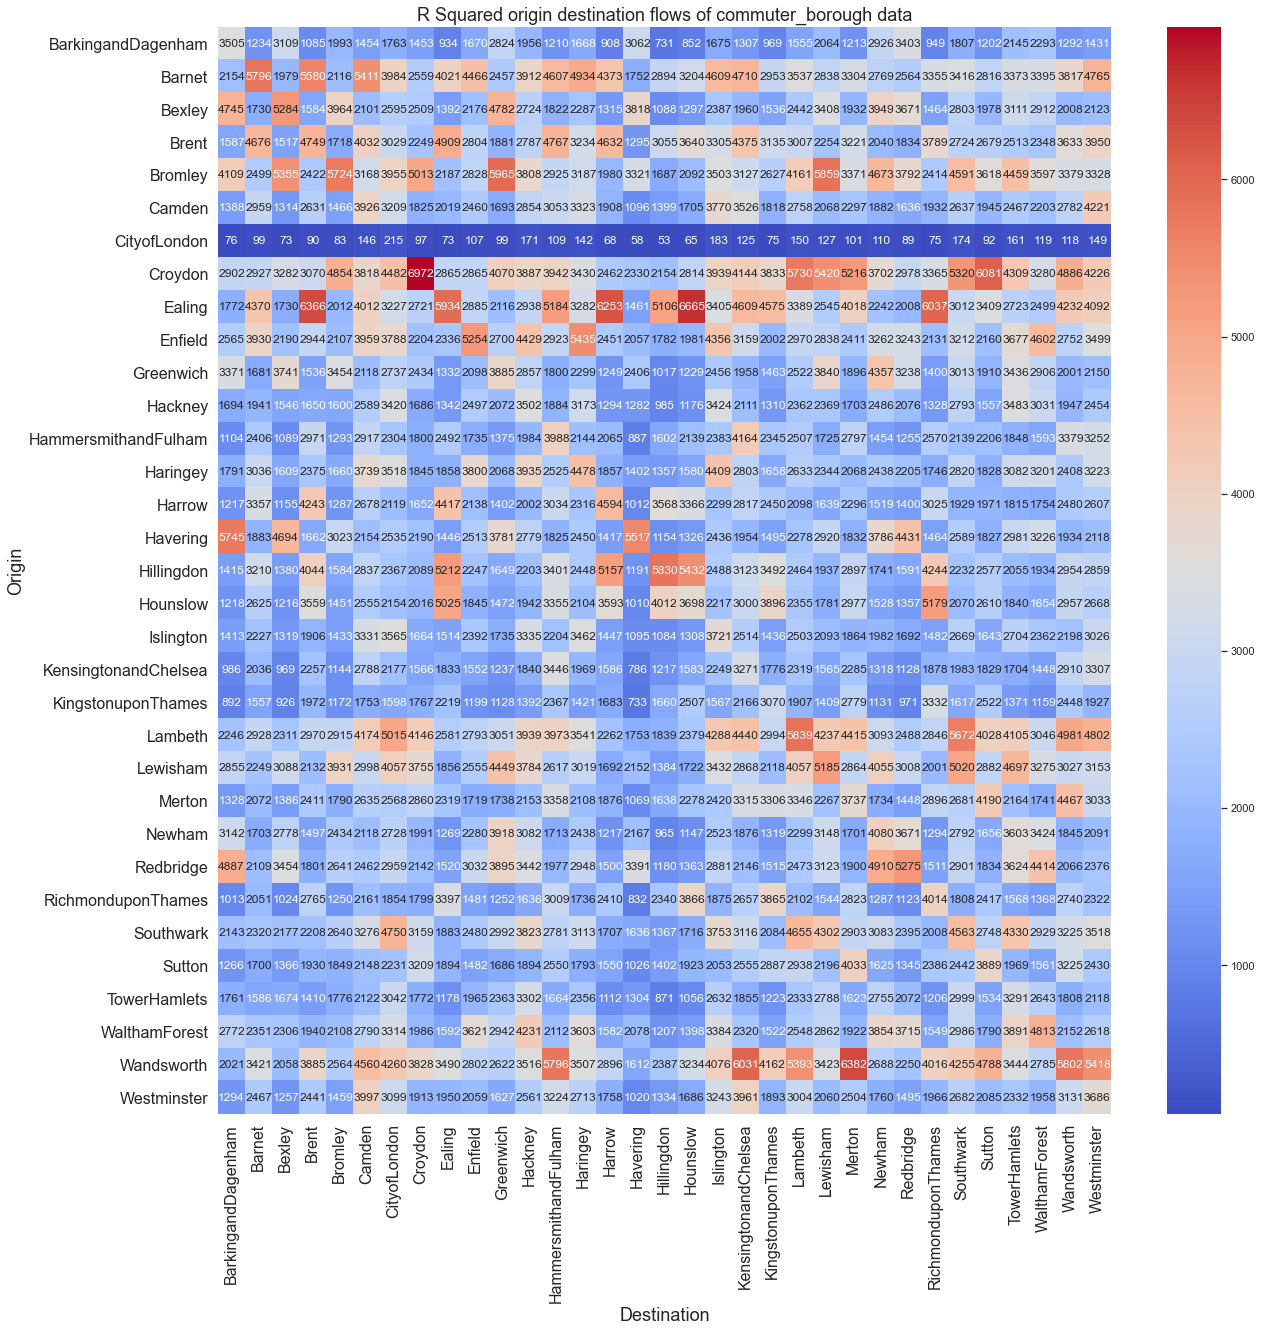

In [51]:
# Change font scaling
sns.set(font_scale=1)
# Set plot size
plt.figure(figsize=(20,20))
# Add heatmap
flow_heatmap = sns.heatmap(estimated_matrix,
                            annot=True,
                            cmap="coolwarm",
                            fmt='d',
                            xticklabels=destinations,
                            yticklabels=origins)
# Add x,y axes labels
plt.xlabel("Destination",fontsize=18)
plt.ylabel("Origin",fontsize=18)
# Add title
plt.title('{} origin destination flows of {} data'.format(method.title().replace('_',' '),dataset), fontsize=18)
# Increase tick font size
plt.tick_params(labelsize=16)

# Save figure to output
plt.savefig('../data/output/{}/{}/figures/{}.png'.format(dataset,method.lower(),filename))

In [31]:
def SRMSE(t_hat:np.array,actual_flows:np.array):
    """ Computes standardised root mean square error. See equation (22) of
    "A primer for working with the Spatial Interaction modeling (SpInt) module
    in the python spatial analysis library (PySAL)" for more details.

    Parameters
    ----------
    t_hat : np.array [NxM]
        Estimated flows.
    actual_flows : np.array [NxM]
        Actual flows.

    Returns
    -------
    float
        Standardised root mean square error of t_hat.

    """
    if actual_flows.shape[0] != t_hat.shape[0]:
        raise ValueError(f'Actual flows have {actual_flows.shape[0]} rows whereas \hat{T} has {t_hat.shape[0]}.')
    if actual_flows.shape[1] != t_hat.shape[1]:
        raise ValueError(f'Actual flows have {actual_flows.shape[1]} columns whereas \hat{T} has {t_hat.shape[1]}.')

    return ((np.sum((actual_flows - t_hat)**2) / (N*M))**.5) / (np.sum(actual_flows) / (N*M))


In [33]:
SRMSE(estimated_matrix,actual_matrix)

2.141598656335155

## Destination demands

In [41]:
np.sum(estimated_matrix,axis=0)

array([72377, 83136, 70356, 86086, 72495, 96927, 98618, 80871, 80289,
       79800, 82926, 94600, 95145, 92061, 73854, 57611, 61349, 73427,
       97341, 98063, 76802, 96634, 90178, 89285, 86219, 76847, 80852,
       96351, 82301, 94275, 85473, 94984, 98940])

In [42]:
np.sum(actual_matrix,axis=0)

array([ 38747,  74789,  45422,  68322,  76224, 174520, 211588,  96120,
        83997,  62826,  51039,  56775,  79612,  48207,  46107,  53035,
       103596,  73846, 106333,  80001,  43693,  88079,  51183,  49149,
        52103,  49700,  47304, 107899,  47466, 116374,  45997,  77197,
       389753])

## Origin supplies

In [44]:
np.sum(estimated_matrix,axis=1)

array([ 57642, 118420,  84897, 101368, 118724,  78170,   3672, 129555,
       120829, 101309,  79790,  69767,  71912,  83299,  77656,  85365,
        92284,  82939,  70323,  61942,  57322, 116090, 101937,  80051,
        75909,  89652,  69389,  95783,  70433,  65194,  85859, 123372,
        75619])

In [45]:
np.sum(actual_matrix,axis=1)

array([ 57657, 118436,  84912, 101383, 118739,  78187,   3693, 129572,
       120845, 101325,  79805,  69782,  71927,  83316,  77669,  85381,
        92299,  82957,  70337,  61957,  57336, 116105, 101953,  80066,
        75928,  89671,  69403,  95799,  70449,  65213,  85876, 123389,
        75636])

In [46]:
np.sum(actual_matrix,axis=1)-np.sum(estimated_matrix,axis=1)

array([15, 16, 15, 15, 15, 17, 21, 17, 16, 16, 15, 15, 15, 17, 13, 16, 15,
       18, 14, 15, 14, 15, 16, 15, 19, 19, 14, 16, 16, 19, 17, 17, 17])